# Modeling
Shpaner, Leonid  
Robinson, Christopher  
Luis-Estrada, Jose  

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/Shared drives/Capstone - Best Group/navigating_crime/Code Library

/content/drive/Shared drives/Capstone - Best Group/navigating_crime/Code Library


In [3]:
####################################
## import the requisite libraries ##
####################################
import os
import csv
import pandas as pd
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# import modeling libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, mean_squared_error,\
precision_score, recall_score, f1_score, accuracy_score,\
confusion_matrix, plot_confusion_matrix, classification_report

import warnings
# suppress warnings for cleaner output
warnings.filterwarnings('ignore')
# suppress future warnings for cleaner output
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [4]:
# set random state for reproducibility
rstate = 222

In [5]:
# check current working directory
current_directory = os.getcwd()
current_directory

'/content/drive/Shareddrives/Capstone - Best Group/navigating_crime/Code Library'

### Assign Paths to Folders

In [6]:
# path to data folder
data_path1 = '/content/drive/Shareddrives/Capstone - Best Group/' \
           + 'navigating_crime/Data Folder/'

# path to the training file
data_path2 = '/content/drive/Shareddrives/Capstone - Best Group/' \
           + 'navigating_crime/Data Folder/train_set.csv'

# path to the validation file
data_path3 = '/content/drive/Shareddrives/Capstone - Best Group/' \
           + 'navigating_crime/Data Folder/valid_set.csv'    

# path to the feature engineered original dataframe (for eda purposes)
data_path4 = '/content/drive/Shareddrives/Capstone - Best Group/' \
           + 'Final_Data_20220719/df.csv'

# path to the image library
image_path = '/content/drive/Shareddrives/Capstone - Best Group/' \
           + 'navigating_crime/Image Folder'        

In [7]:
# bring in original dataframe only for join purposes
train_set = pd.read_csv(data_path2).set_index('OBJECTID')
valid_set = pd.read_csv(data_path3).set_index('OBJECTID')

In [8]:
# print the training 
print('The training set is', train_set.shape[0], 'rows and', train_set.shape[1],
      'columns.')
print('The validation set is', valid_set.shape[0], 'rows and', valid_set.shape[1],
      'columns.')

The training set is 21036 rows and 36 columns.
The validation set is 10518 rows and 36 columns.


In [9]:
# subset the inputs for train and val (X_train, y_train, respectively) as 
# only input features, omitting the crime code truthing columns.
X_train = train_set.drop(columns=['Crime_Code'])
y_train = pd.DataFrame(train_set['Crime_Code'])

X_val = valid_set.drop(columns=['Crime_Code'])
y_val = pd.DataFrame(valid_set['Crime_Code'])

### Quadratic Discriminant Analysis (QDA)

In [10]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
qda_proba = qda.predict_proba(X_val)[:,1]

## Logistic Regression

In [11]:
def lr_hp(solver, penalty, l1_ratio, max_iter, rstate): 
    '''
    Inputs: 
        solver = hyperparameter
        penalty = 
        ratio = 
        cost = 
        maxiter = 
        rstate = random state for reproducibility
        x = width size of figure size
        y =  height size of figure size
    '''
    # manually tuning the logistic regression model
    C = list(range(1, 100, 10))
    LRtrainAcc = []
    LRvalAcc = []
    for cost in C:
        lr = LogisticRegression(solver=solver, penalty=penalty, l1_ratio=l1_ratio,
                                C=cost, max_iter=max_iter, random_state=rstate)
        lr.fit(X_train, y_train)

        # Predict on train set
        lr_pred_train = lr.predict(X_train)
        # Predict on val set
        tuned_lr = lr.predict(X_val)
        LRtrainAcc.append(accuracy_score(y_val, tuned_lr))
        LRvalAcc.append(accuracy_score(y_val, tuned_lr))
        print('Cost = %2.2f \t Validation Accuracy = %2.2f \t Training ' \
              'Accuracy = %2.2f'% (cost,accuracy_score(y_val, tuned_lr),
                               accuracy_score(y_train, lr_pred_train)))

    # plot cost by accuracy
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(C, LRtrainAcc, 'ro-', C, LRvalAcc,'bv--')
    ax.legend(['Training Accuracy','Validation Accuracy'])
    plt.title('Logistic Regression: Accuracy vs. Cost')
    ax.set_xlabel('Cost'); ax.set_xscale('log')
    ax.set_ylabel('Accuracy')
    plt.savefig(image_path + '/log_reg_accuracy.png', bbox_inches = 'tight')

    # accuracy and classification report (tuned model)
    print()
    print('Tuned Logistic Regression Model')
    print('Accuracy Score')
    print(accuracy_score(y_val, tuned_lr))
    print('Classification Report \n', classification_report(y_val, tuned_lr))

Cost = 1.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 11.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 21.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 31.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 41.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 51.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 61.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 71.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 81.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 91.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61

Tuned Logistic Regression Model
Accuracy Score
0.6217912150598973
Classification Report 
               precision    recall  f1-score   support

           0       0.62      0.47      0.54      4861
           1       0.62      0.75      0.68      5657

    accuracy                           0.62     10518
  

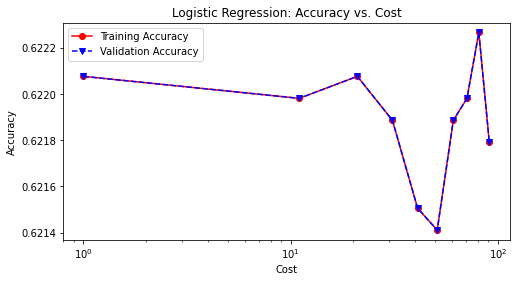

In [12]:
lr_hp(solver='lbfgs', penalty='l2', l1_ratio=0.01, max_iter=200, rstate=rstate)

Cost = 1.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 11.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 21.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 31.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 41.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 51.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 61.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 71.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 81.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61
Cost = 91.00 	 Validation Accuracy = 0.62 	 Training Accuracy = 0.61

Tuned Logistic Regression Model
Accuracy Score
0.6219813652785701
Classification Report 
               precision    recall  f1-score   support

           0       0.62      0.47      0.54      4861
           1       0.62      0.75      0.68      5657

    accuracy                           0.62     10518
  

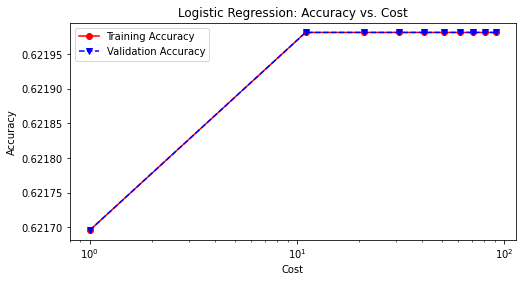

In [13]:
lr_hp(solver='saga', penalty='elasticnet', l1_ratio=0.01, max_iter=200, 
      rstate=rstate)

In [14]:
def log_reg(solver, penalty, l1_ratio, max_iter, rstate):
    lr = LogisticRegression(solver=solver, penalty=penalty, l1_ratio=l1_ratio,
                            max_iter=max_iter, random_state=rstate)
    lr.fit(X_train, y_train)
    # Predict on val set
    tuned_lr = lr.predict(X_val)
    return lr

In [15]:
lr = log_reg(solver='saga', penalty='elasticnet', l1_ratio=0.01, 
        max_iter=200, rstate=rstate)
# extract predicted probabilities for validation set
lr_proba = lr.predict_proba(X_val)[:, 1]

### Decision Tree Classifier

In [16]:
tree = DecisionTreeClassifier(max_depth=15)
tree.fit(X_train, y_train)
tree_proba = tree.predict_proba(X_val)[:,1]

### Random Forest Classifier

In [17]:
def rf_hp(criterion, rstate):
    # Random Forest Tuning (Manual)
    rf_train_accuracy = []
    rf_val_accuracy = []
    max_depth = list(range(15, 21))
    for n in max_depth:
        rf = RandomForestClassifier(max_depth=n, criterion=criterion, 
                                    random_state=rstate)
        rf = rf.fit(X_train, y_train)
        rf_pred_train = rf.predict(X_train)
        rf_pred_val = rf.predict(X_val)
        rf_train_accuracy.append(accuracy_score(y_train, rf_pred_train))
        rf_val_accuracy.append(accuracy_score(y_val, rf_pred_val))
        print('Max Depth = %2.0f \t val Accuracy = %2.2f \t' \
              'Training Accuracy = %2.2f'% (n, accuracy_score(y_val, 
                                                              rf_pred_val),
                                            accuracy_score(y_train, 
                                                           rf_pred_train)))
    # max_depth = list(range(1, 15))
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(max_depth, rf_train_accuracy, 'bv--', label='Training Accuracy')
    ax.plot(max_depth, rf_val_accuracy, 'ro--', label='Validaiton Accuracy')
    ax.legend(['Training Accuracy','Validation Accuracy'])
    ax.set_title('Random Forest Accuracy')
    ax.set_xlabel('Depth')
    ax.set_ylabel('Accuracy')

    # accuracy and classification report
    print()
    print('Tuned Random Forest Model')
    print('Accuracy Score', '\n')
    print(accuracy_score(y_val, rf_pred_val))
    print('Classification Report \n', 
          classification_report(y_val, rf_pred_val))

Max Depth = 15 	 val Accuracy = 0.77 	Training Accuracy = 0.83
Max Depth = 16 	 val Accuracy = 0.79 	Training Accuracy = 0.86
Max Depth = 17 	 val Accuracy = 0.81 	Training Accuracy = 0.88
Max Depth = 18 	 val Accuracy = 0.82 	Training Accuracy = 0.90
Max Depth = 19 	 val Accuracy = 0.84 	Training Accuracy = 0.92
Max Depth = 20 	 val Accuracy = 0.85 	Training Accuracy = 0.93

Tuned Random Forest Model
Accuracy Score 

0.8464536984217532
Classification Report 
               precision    recall  f1-score   support

           0       0.86      0.79      0.83      4861
           1       0.83      0.89      0.86      5657

    accuracy                           0.85     10518
   macro avg       0.85      0.84      0.84     10518
weighted avg       0.85      0.85      0.85     10518



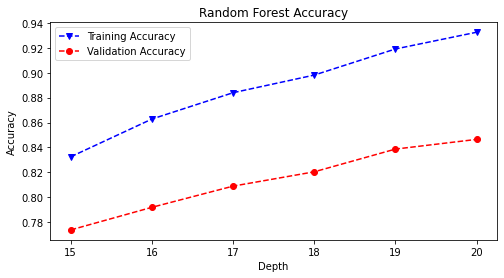

In [18]:
rf_hp('gini', rstate)

Max Depth = 15 	 val Accuracy = 0.77 	Training Accuracy = 0.83
Max Depth = 16 	 val Accuracy = 0.79 	Training Accuracy = 0.85
Max Depth = 17 	 val Accuracy = 0.80 	Training Accuracy = 0.87
Max Depth = 18 	 val Accuracy = 0.82 	Training Accuracy = 0.90
Max Depth = 19 	 val Accuracy = 0.83 	Training Accuracy = 0.91
Max Depth = 20 	 val Accuracy = 0.85 	Training Accuracy = 0.93

Tuned Random Forest Model
Accuracy Score 

0.8495911770298535
Classification Report 
               precision    recall  f1-score   support

           0       0.87      0.80      0.83      4861
           1       0.84      0.89      0.86      5657

    accuracy                           0.85     10518
   macro avg       0.85      0.85      0.85     10518
weighted avg       0.85      0.85      0.85     10518



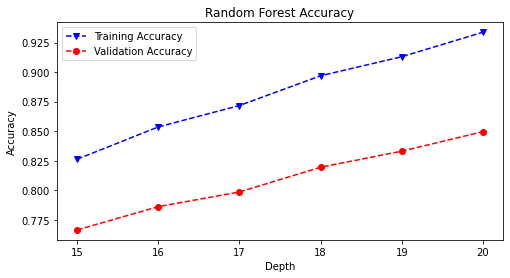

In [19]:
rf_hp('entropy', rstate)

In [20]:
def rand_for(n, criterion, rstate):
    rf = RandomForestClassifier(max_depth=n, criterion=criterion, 
                                random_state=rstate)

    rf.fit(X_train, y_train)
    # Predict on val set
    tuned_rf = rf.predict(X_val)
    return rf

In [21]:
rf = rand_for(20, criterion='entropy', rstate=rstate)
# extract predicted probabilities for validation set
rf_proba = rf.predict_proba(X_val)[:, 1]

In [22]:
def xgb_hp(lr, rstate):
    # XGBoost tuning 
    xgb_train_accuracy = []
    xgb_val_accuracy = []
    max_depth = list(range(20, 31))
    for n in max_depth:
        xgb = XGBClassifier(max_depth=n, tree_method='hist', # speeds up time
                            learning_rate=lr, n_estimators=250, 
                            random_state=rstate, n_jobs=-1) # uses all cores
        xgb = xgb.fit(X_train, y_train)
        xgb_pred_train = xgb.predict(X_train)
        xgb_pred_val = xgb.predict(X_val)
        xgb_train_accuracy.append(accuracy_score(y_train, xgb_pred_train))
        xgb_val_accuracy.append(accuracy_score(y_val, xgb_pred_val))
        print('Max Depth = %2.0f \t Validation Accuracy = %2.2f \t' \
              'Training Accuracy = %2.2f' %(n, accuracy_score(y_val, 
                                            xgb_pred_val),
                                            accuracy_score(y_train, xgb_pred_train)))

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(max_depth, xgb_train_accuracy, 'bv--', label='Training Accuracy')
    ax.plot(max_depth, xgb_val_accuracy, 'ro--', label='Validation Accuracy')
    ax.set_title('XGBoost Accuracy')
    ax.set_xlabel('Depth')
    ax.set_ylabel('Accuracy')
    plt.legend()

    # accuracy and classification report
    print()
    print('Tuned XGBoost Model')
    print('Accuracy Score', '\n')
    print(accuracy_score(y_val, xgb_pred_val))
    print('Classification Report \n', classification_report(y_val, xgb_pred_val))

Max Depth = 20 	 Validation Accuracy = 0.88 	Training Accuracy = 0.98
Max Depth = 21 	 Validation Accuracy = 0.89 	Training Accuracy = 0.98
Max Depth = 22 	 Validation Accuracy = 0.89 	Training Accuracy = 0.98
Max Depth = 23 	 Validation Accuracy = 0.89 	Training Accuracy = 0.98
Max Depth = 24 	 Validation Accuracy = 0.89 	Training Accuracy = 0.98
Max Depth = 25 	 Validation Accuracy = 0.89 	Training Accuracy = 0.98
Max Depth = 26 	 Validation Accuracy = 0.89 	Training Accuracy = 0.98
Max Depth = 27 	 Validation Accuracy = 0.89 	Training Accuracy = 0.98
Max Depth = 28 	 Validation Accuracy = 0.88 	Training Accuracy = 0.98
Max Depth = 29 	 Validation Accuracy = 0.89 	Training Accuracy = 0.98
Max Depth = 30 	 Validation Accuracy = 0.89 	Training Accuracy = 0.98

Tuned XGBoost Model
Accuracy Score 

0.8855295683590036
Classification Report 
               precision    recall  f1-score   support

           0       0.88      0.87      0.88      4861
           1       0.89      0.90      0

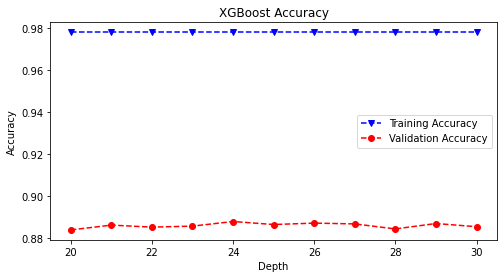

In [23]:
xgb_hp(lr=0.5, rstate=rstate)

In [24]:
def xgb(n, lr, rstate):
  xgb = XGBClassifier(max_depth=n, learning_rate=lr, 
                      random_state=rstate)
  xgb.fit(X_train, y_train)
  # Predict on val set
  tuned_xgb = xgb.predict(X_val)
  return xgb

In [25]:
xgb = xgb(n=31, lr=0.5, rstate=rstate)
# extract predicted probabilities for validation set
xgb_proba = xgb.predict_proba(X_val)[:, 1]

In [26]:
def roc_plots(est_name, name, ax=None):
    roc = metrics.roc_curve(y_val, est_name)
    fpr,tpr,thresholds = metrics.roc_curve(y_val, est_name)
    auc = metrics.auc(fpr, tpr)

    if ax is None:
      fig, ax = plt.subplots(figsize=(15, 10))
      plt.title('ROC Curves', fontsize=12)
      plt.xlabel('',fontsize=12) 
      plt.ylabel('',fontsize=12) 
    ax.plot(fpr, tpr, label=f'{name}: auc = {auc:.2}')
    ax.plot([0, 1], [0, 1], linestyle='--', color='#174ab0')
    return ax    

In [27]:
data_path1

'/content/drive/Shareddrives/Capstone - Best Group/navigating_crime/Data Folder/'

In [28]:
models = pd.DataFrame({'qda': qda_proba, 'log': lr_proba, 'rf': rf_proba, 
                       'tree': tree_proba, 'xgb': xgb_proba, 
                       'y_val': y_val['Crime_Code'].values})
models.to_pickle(data_path1 + 'models.pkl')
models.to_csv(data_path1 + 'models.csv', index=False)
models.head()

,qda,log,rf,tree,xgb,y_val
0,1.782625e-10,0.658370,0.369808,0.628533,0.020489,0
1,9.971863e-01,0.635430,0.802895,0.720096,0.991202,1
2,1.070735e-06,0.399391,0.327498,0.419451,0.179226,1
3,8.148866e-03,0.513235,0.609281,0.058824,0.928699,1
4,1.293167e-172,0.465000,0.370703,0.419451,0.521080,1


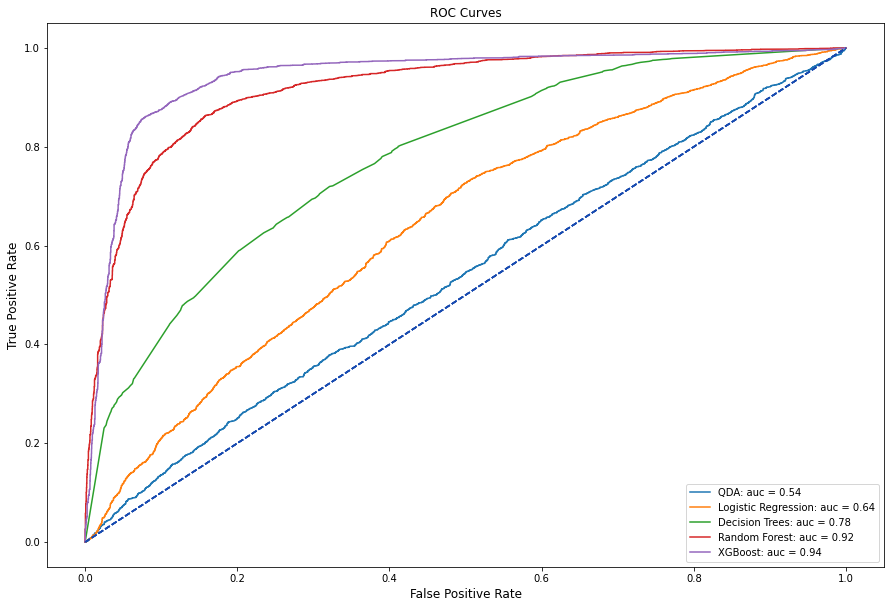

In [29]:
ax = roc_plots(est_name=qda_proba, name='QDA')
roc_plots(est_name=lr_proba, name='Logistic Regression', ax=ax)
roc_plots(est_name=tree_proba, name='Decision Trees', ax=ax)
roc_plots(est_name=rf_proba, name='Random Forest', ax=ax)
roc_plots(est_name=xgb_proba, name='XGBoost', ax=ax)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right');

## Model Evaluation

### Confusion Matrices

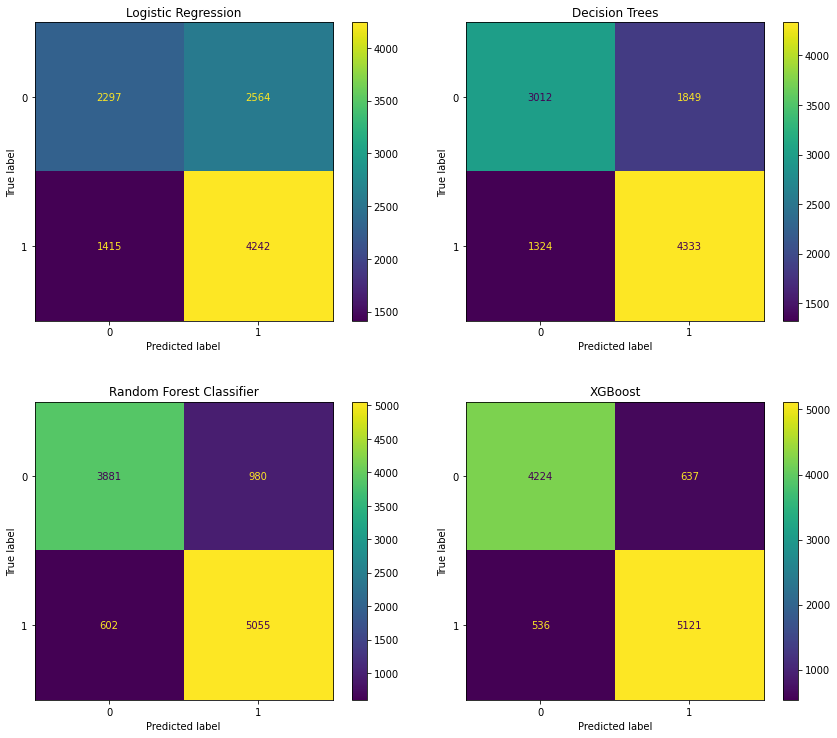

In [30]:
fig = plt.figure(figsize=(12, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
fig.tight_layout(w_pad=2, h_pad= 6)

# Logistic Regression confusion matrix
plot_confusion_matrix(lr, X_val, y_val, ax=ax1)
ax1.set_title('Logistic Regression')

# Decision Tree confusion matrix
plot_confusion_matrix(tree, X_val, y_val, ax=ax2)
ax2.set_title('Decision Trees')

# Random Forest confusion matrix
plot_confusion_matrix(rf, X_val, y_val, ax=ax3)
ax3.set_title('Random Forest Classifier')

# Random Forest confusion matrix
plot_confusion_matrix(xgb, X_val, y_val, ax=ax4)
ax4.set_title('XGBoost')

plt.show()

In [31]:
df_predictions = valid_set.copy()
df_preds = pd.concat([X_val, y_val], axis=1)
df_preds['Predictions'] = xgb_proba

In [32]:
df_preds.head()

,77th_Street,Central,Devonshire,Foothill,Harbor,Hollenbeck,Hollywood,Mission,N_Hollywood,Newton,...,Park_Playground,Parking_Lot,Sidewalk,Street,Vacant_Lot,Vict_Age,Month_No,Gender,Crime_Code,Predictions
OBJECTID,,,,,,,,,,,,,,,,,,,,,
62203,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,46,6,2,0,0.020489
233319,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,32,6,2,1,0.991202
95157,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,26,6,1,1,0.179226
83900,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,28,1,1,1,0.928699
61476,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,57,5,1,1,0.521080


In [33]:
df_preds.columns

Index(['77th_Street', 'Central', 'Devonshire', 'Foothill', 'Harbor',
       'Hollenbeck', 'Hollywood', 'Mission', 'N_Hollywood', 'Newton',
       'Northeast', 'Olympic', 'Pacific', 'Rampart', 'Southeast', 'Southwest',
       'Topanga', 'Van_Nuys', 'West_LA', 'West_Valley', 'Wilshire',
       'Afternoon', 'Evening', 'Morning', 'Night', 'Alley', 'Driveway',
       'Park_Playground', 'Parking_Lot', 'Sidewalk', 'Street', 'Vacant_Lot',
       'Vict_Age', 'Month_No', 'Gender', 'Crime_Code', 'Predictions'],
      dtype='object')

In [34]:
df_preds.to_csv(data_path1 + 'df_preds.csv')

In [35]:
def plot_roc_preds(df, title, column):   
    ''' 
    This function creates roc curve plot for predictions
    Inputs:
        df_preds: dataframe with appended predictions
        title: title of the plot
        column: column to look at (i.e., 'Age', etc.)
        dictionary: key-value pair mapping for column
    '''
    
    # filter by each unique value in column    
    for value in df[column].unique():
        filtered_preds = df[df[column]==value]
        
        if filtered_preds.shape[0] > 0:
          # plot roc curve
          fpr, tpr, thresholds = metrics.roc_curve(filtered_preds['Crime_Code'], 
                                                  filtered_preds['Predictions'])
          y_preds = df[df[column]==value]['Predictions']
          y_true = df[df[column]==value]['Crime_Code']
          count = len(y_true)
          len_h0 = len(y_true[y_true==0])
          len_h1 = len(y_true[y_true==1])
              
          roc_auc = metrics.auc(fpr, tpr)
          plt.rcParams["figure.figsize"] = [16, 10]
          plt.title(title)
          plt.plot(fpr, tpr, label = f'AUC for {value} = {roc_auc:.3f},'
                                    f' count: {len(y_true)}, H0: {len_h0},'
                                    f' H1: {len_h1}')
          plt.plot([0, 1], [0, 1], 'r--')
          plt.xlim([0, 1])
          plt.ylim([0, 1])
          plt.xlabel('False Positive Rate')
          plt.ylabel('True Positive Rate')
          plt.legend(loc="lower right")   


In [36]:
df = pd.read_csv(data_path4).set_index('OBJECTID')

In [37]:
# join columns of interest from eda datframe to the prediction dataframe
# for further ROC Curve analysis
df_preds_roc= df_preds.join(df[['Type', 'age_bin', 'Victim_Sex', 'Victim_Desc', 
                                'Time_of_Day', 'Month', 'AREA_NAME']],
                                 how='left')

In [38]:
# drop individual streets from new dataframe, since we are not interested in
# investing performance operating points at this granularity. However, 
# street tpes, age groups, time of day, and month are retained such that
# this analysis can be made
df_preds_roc = df_preds_roc.drop(columns=['77th_Street', 'Central', 'Devonshire', 
                                          'Foothill', 'Harbor', 'Hollenbeck', 
                                          'Hollywood', 'Mission', 'N_Hollywood',
                                          'Newton','Northeast', 'Olympic', 
                                          'Pacific', 'Rampart', 'Southeast', 
                                          'Southwest','Topanga', 'Van_Nuys', 
                                          'West_LA', 'West_Valley', 'Wilshire',
                                          # remove individual time of day cols
                                          # since these are already contained
                                          # within 'Time_of_Day' col
                                          'Afternoon', 'Evening', 'Morning', 
                                          'Night',
                                          # remove individual street type cols
                                          # since these are already contained
                                          # within 'Type' column
                                          'Alley', 'Driveway', 'Park_Playground', 
                                          'Parking_Lot', 'Sidewalk', 'Street', 
                                          'Vacant_Lot', 
                                          # remove 'Month_No' col since relvant
                                          # info is contained within 'Month' col
                                          'Month_No',
                                          # remove 'Vict_Age' since we have 
                                          # binned it as 'age_bin'
                                          'Vict_Age',
                                          # drop gender in lieu of 'Victim_Sex'
                                          'Gender'],
                                          errors='ignore')

In [39]:
df_preds_roc.head().T

OBJECTID,62203,233319,95157,83900,61476
Crime_Code,0,1,1,1,1
Predictions,0.020489,0.991202,0.179226,0.928699,0.52108
Type,Minor,Minor,Minor,Minor,Minor
age_bin,45-50,30-35,25-30,25-30,55-60
Victim_Sex,M,M,F,F,F
Victim_Desc,Other Asian,Hispanic/Latin/Mexican,Hispanic/Latin/Mexican,Hispanic/Latin/Mexican,White
Time_of_Day,Evening,Evening,Evening,Night,Evening
Month,June,June,June,January,May
AREA_NAME,Newton,Newton,Hollywood,Newton,Central


In [40]:
df_preds_roc.columns

Index(['Crime_Code', 'Predictions', 'Type', 'age_bin', 'Victim_Sex',
       'Victim_Desc', 'Time_of_Day', 'Month', 'AREA_NAME'],
      dtype='object')

In [41]:
options = {'age_bin': 'Age Bin',  'Type': 'Type', 'Victim_Sex': 'Victim Sex', 
           'Victim_Desc': 'Victim Descent', 'Time_of_Day': 'Time of Day', 
           'Month': 'Month', 'AREA_NAME': 'Area Name', 'Premises': 'Premises'}

df_preds_roc = df_preds_roc.rename(columns=options)
df_preds_roc

,Crime_Code,Predictions,Type,Age Bin,Victim Sex,Victim Descent,Time of Day,Month,Area Name
OBJECTID,,,,,,,,,
62203,0,0.020489,Minor,45-50,M,Other Asian,Evening,June,Newton
233319,1,0.991202,Minor,30-35,M,Hispanic/Latin/Mexican,Evening,June,Newton
95157,1,0.179226,Minor,25-30,F,Hispanic/Latin/Mexican,Evening,June,Hollywood
83900,1,0.928699,Minor,25-30,F,Hispanic/Latin/Mexican,Night,January,Newton
61476,1,0.521080,Minor,55-60,F,White,Evening,May,Central
...,...,...,...,...,...,...,...,...,...
91821,0,0.010311,Primary,55-60,M,Black,Morning,February,Wilshire
171199,1,0.929131,Primary,50-55,M,White,Morning,February,West_LA
220540,1,0.937873,Secondary,50-55,M,Black,Afternoon,June,Central


In [42]:
# write out the df_preds (+) joined columns of interest file to csv on path
df_preds_roc.to_csv(data_path1 + 'df_preds_roc.csv', index=False)

### ROC Curves by Month of Crime

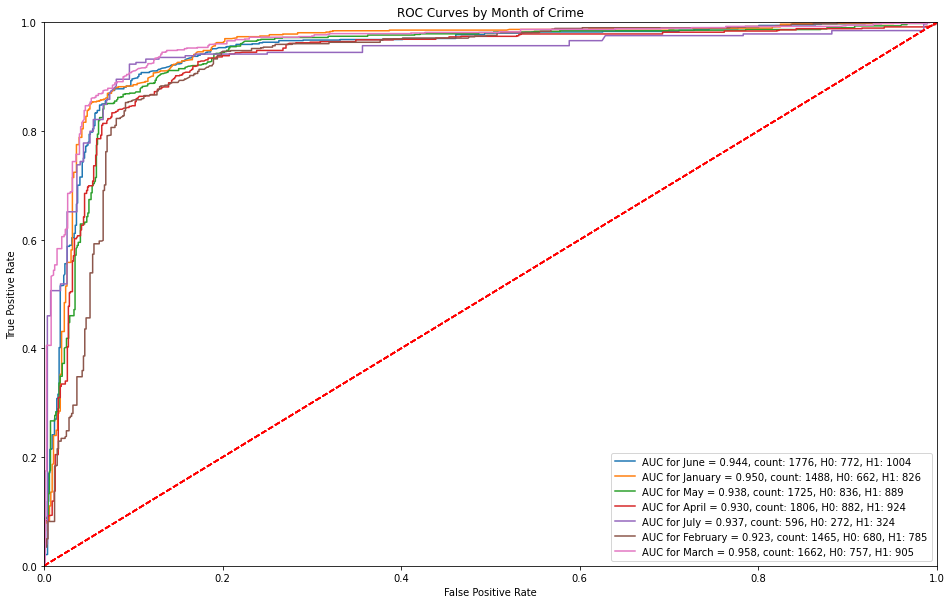

In [43]:
plot_roc_preds(df_preds_roc, 'ROC Curves by Month of Crime', 'Month')

### ROC Curves by Time of Day

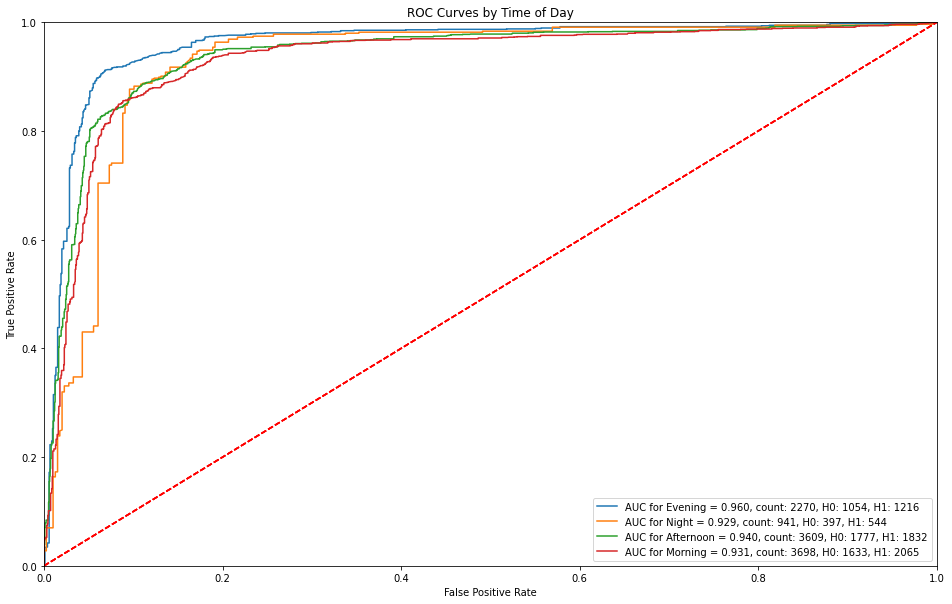

In [44]:
plot_roc_preds(df_preds_roc, 'ROC Curves by Time of Day', 'Time of Day')

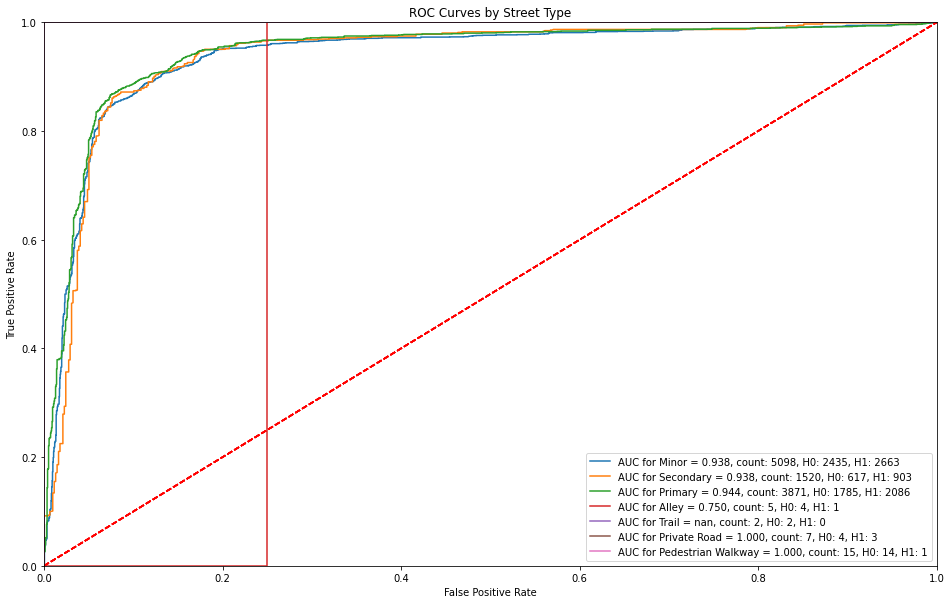

In [45]:
plot_roc_preds(df_preds_roc, 'ROC Curves by Street Type', 'Type')

In [46]:
df_preds_roc.columns

Index(['Crime_Code', 'Predictions', 'Type', 'Age Bin', 'Victim Sex',
       'Victim Descent', 'Time of Day', 'Month', 'Area Name'],
      dtype='object')

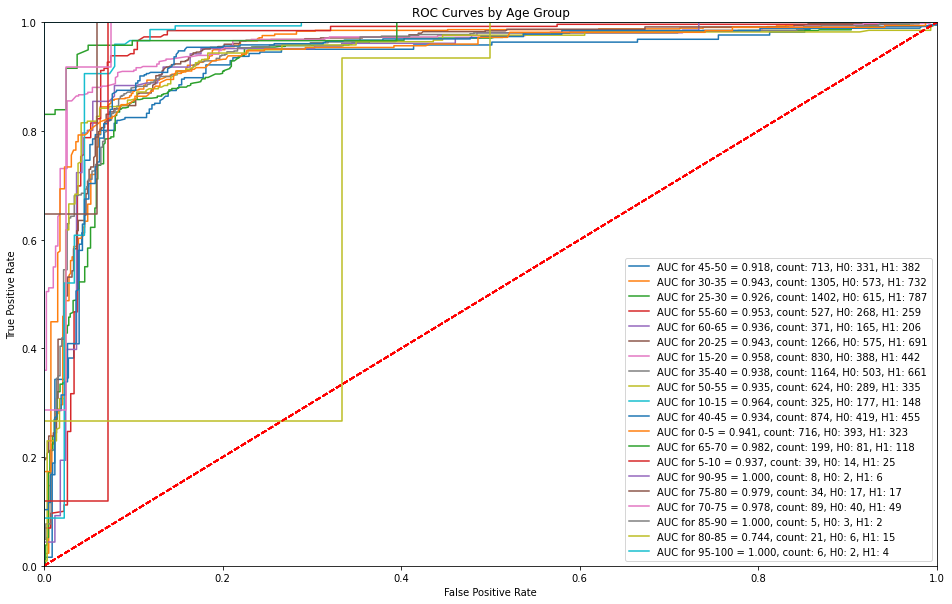

In [47]:
plot_roc_preds(df_preds_roc, 'ROC Curves by Age Group', 'Age Bin')

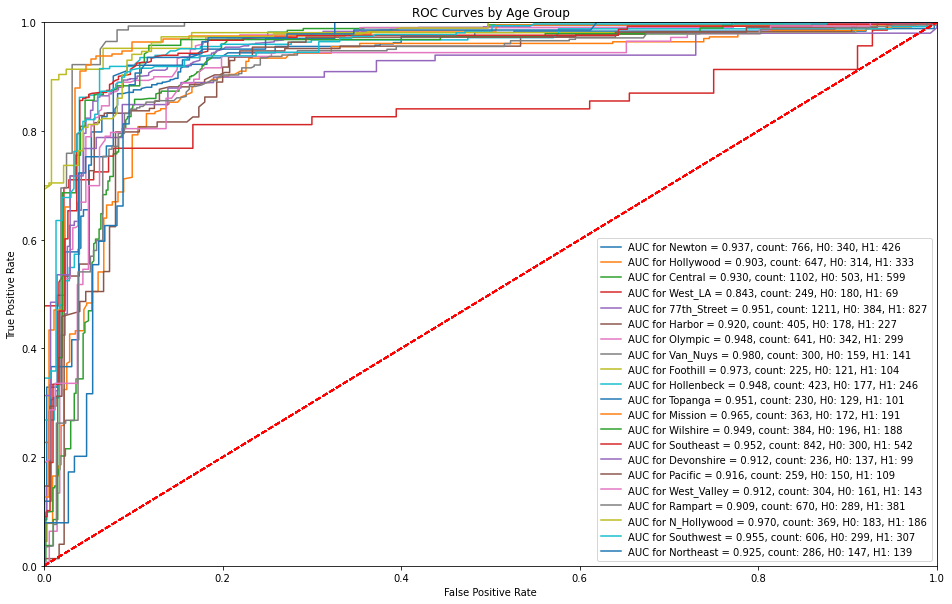

In [48]:
plot_roc_preds(df_preds_roc, 'ROC Curves by Age Group', 'Area Name')